In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [82]:
# read in training data
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
train.shape

(43590, 39)

Look at **missingness** in the data: We miss a number of data about the last years the residence was remodeled.

<AxesSubplot:>

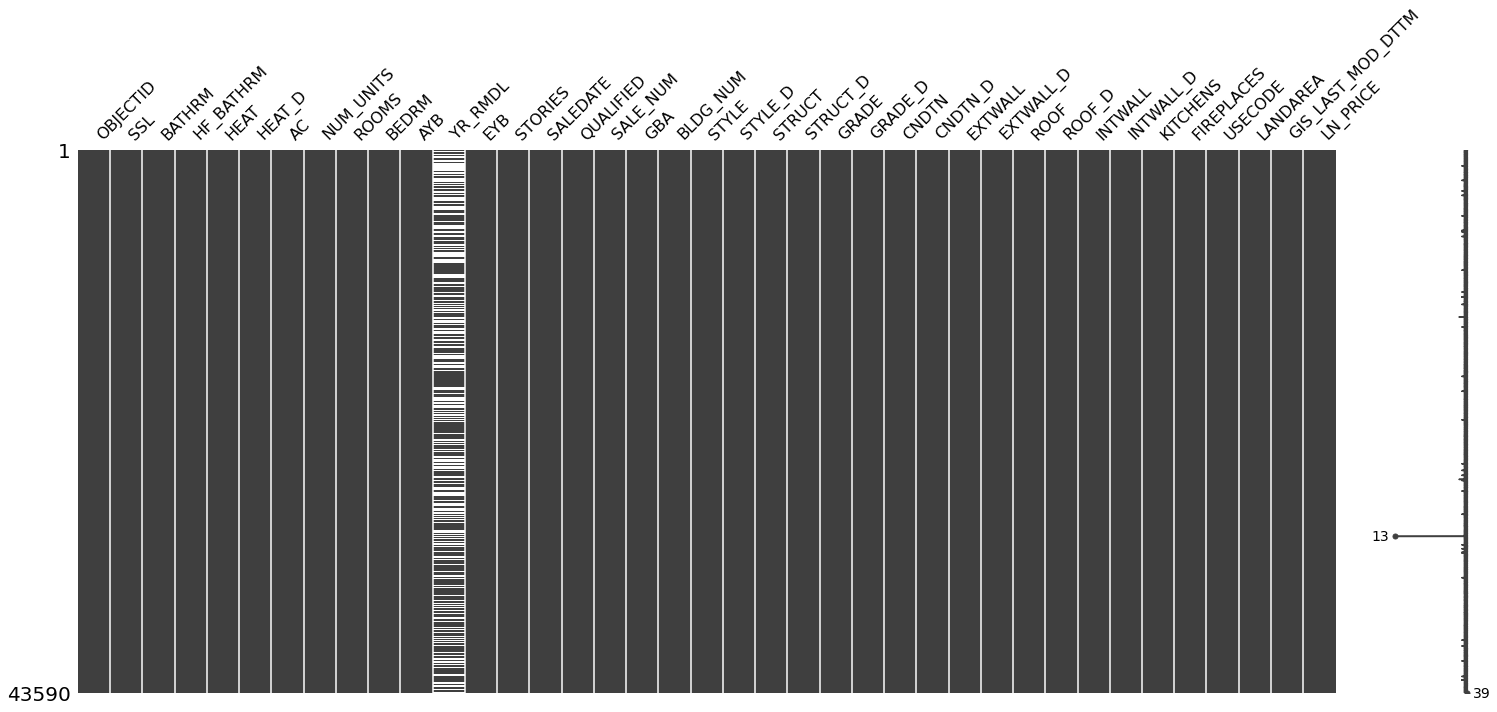

In [83]:
miss.matrix(train)

In [119]:
# Drop all observations where the outcome is missing 
train = train.dropna()
test = test.dropna()

# Only houses that are sold
train = train[train.LN_PRICE > 1]
test = test[test.LN_PRICE > 1]

In [120]:
# Select predators
# Use bathroom, bedroom, biulding constraction year, rebuilding year, land area and grade code as predators.
train_y = train['LN_PRICE']
train_x = train[['BATHRM', 'BEDRM', 'YR_RMDL', 'LANDAREA','GRADE','AYB']]
test_y = test['LN_PRICE']
test_x = test[['BATHRM', 'BEDRM', 'YR_RMDL', 'LANDAREA','GRADE','AYB']]

# Fix scales of Land Area
train_x['LANDAREA'] = np.log(train_x['LANDAREA'])
test_x['LANDAREA'] = np.log(test_x['LANDAREA'])

## Pre-Processing

In [86]:
# rescale our training data
scaler = pp.MinMaxScaler()
col_names = list(train_x)
train_x = scaler.fit_transform(train_x)

In [87]:
# Convert back into data frame
train_x = pd.DataFrame(train_x,columns=col_names)
train_x

,BATHRM,BEDRM,YR_RMDL,LANDAREA,GRADE,AYB
0,0.272727,0.074074,0.998499,0.354963,0.416667,0.962283
1,0.181818,0.074074,0.990995,0.546214,0.500000,0.962779
2,0.181818,0.074074,0.992496,0.345348,0.416667,0.935484
3,0.272727,0.074074,0.992496,0.365790,0.250000,0.955831
4,0.272727,0.055556,0.996998,0.279556,0.333333,0.950868
...,...,...,...,...,...,...
24991,0.090909,0.037037,0.978989,0.144743,0.333333,0.948387
24992,0.181818,0.055556,0.996998,0.292711,0.416667,0.950868
24993,0.181818,0.074074,0.985493,0.283199,0.333333,0.946898
24994,0.272727,0.055556,0.996498,0.213070,0.333333,0.948387


## Modeling

In [88]:
# We set the folds index to ensure comparable samples.
fold_generator = KFold(n_splits = 5, shuffle = True)

In [89]:
use_metrics = ["neg_mean_squared_error"]

### Linear Model

In [90]:
lm_scores = cross_validate(LM(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

### KNN

In [91]:
knn_scores = cross_validate(KNN(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

### Decision Tree

In [92]:
dt_scores = cross_validate(DTree(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

#### Plotting a Decision Tree

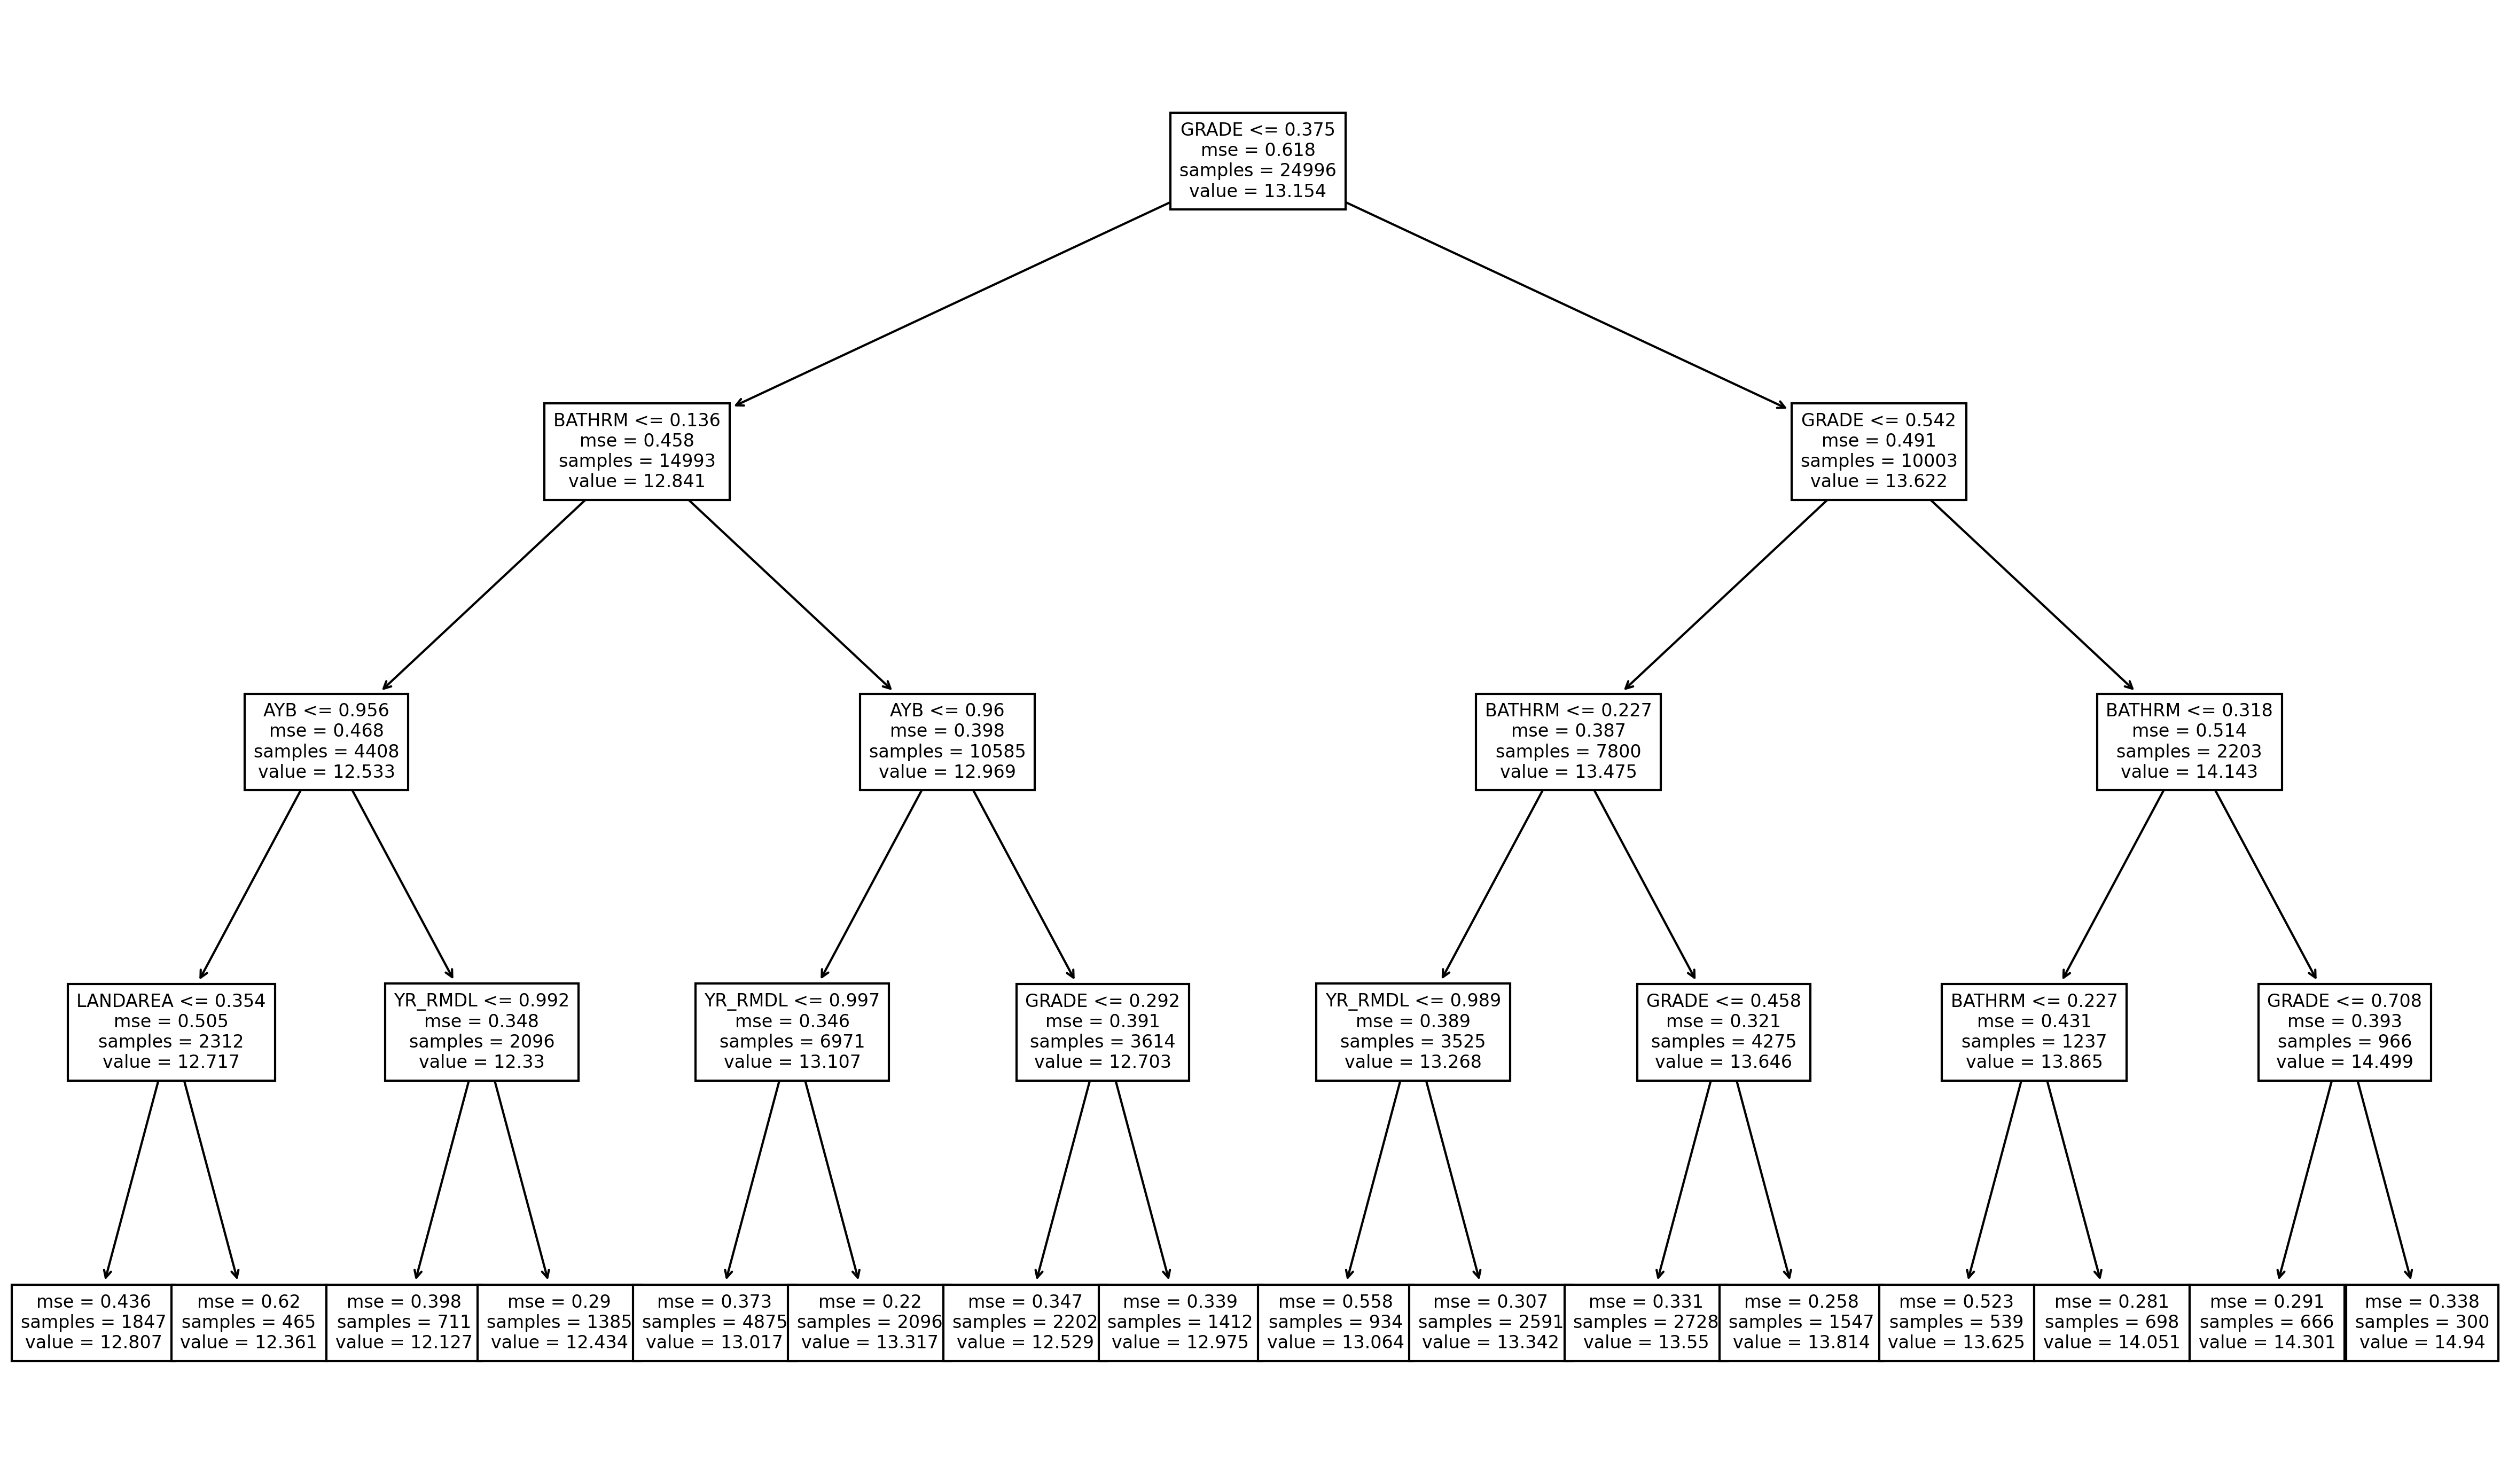

In [93]:
mod = DTree(max_depth=4) 
mod.fit(train_x,train_y) # Fit the mode

# Plot the tree
plt.figure(figsize=(20,12),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=8)

### Random Forest

In [94]:
rf_scores = cross_validate(RF(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

## Compare Models

In [95]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.341928
1,lm,0.460293
2,lm,0.349425
3,lm,0.337774
4,lm,0.369282
5,knn,0.366403
6,knn,0.341305
7,knn,0.377454
8,knn,0.382157
9,knn,0.367295


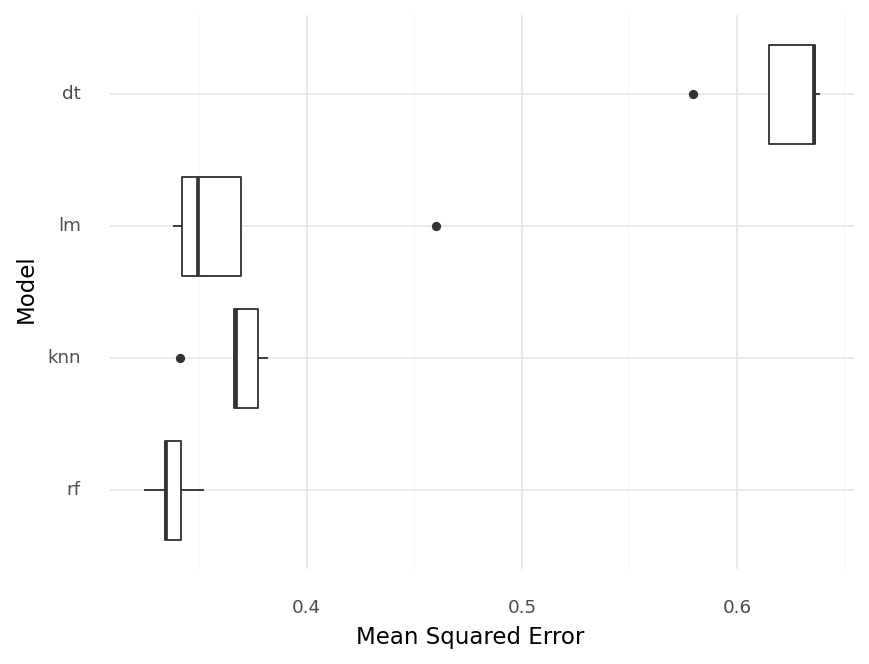

<ggplot: (8782726331895)>

In [96]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

As lower is better, random forest appears to do the best here.

## Tuning Hyper-parameters (by hand)

In [97]:
set_k = dict()
for k in [1,5,10,100,250,500]:
    score = cross_validate(KNN(n_neighbors=k),
                           train_x,train_y, 
                           cv = fold_generator, 
                           scoring =use_metrics)
    s = score['test_neg_mean_squared_error']
    set_k[k] = s.mean()
set_k

{1: -0.5973357604775684,
 5: -0.3675499769901815,
 10: -0.3397615759218781,
 100: -0.33321753669200627,
 250: -0.33943674176490657,
 500: -0.34616378220514293}

## GridSearchCV

In [98]:
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}

In [99]:
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)
tune_knn.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [1, 10, 25, 35, 50, 75, 100, 250]},
             scoring='neg_mean_squared_error')

In [100]:
tune_knn.best_params_

{'n_neighbors': 25}

In [101]:
tune_knn.best_score_

-0.3304052832147731

In [102]:
tune_knn.cv_results_

{'mean_fit_time': array([0.06391892, 0.05587254, 0.05668511, 0.05553861, 0.05651364,
        0.0586431 , 0.05569053, 0.0559032 ]),
 'std_fit_time': array([0.00514891, 0.00465423, 0.00595313, 0.00502555, 0.00532197,
        0.00687065, 0.00500371, 0.00513842]),
 'mean_score_time': array([0.04388919, 0.08662066, 0.12576628, 0.14751077, 0.17992392,
        0.21973352, 0.25866551, 0.48596706]),
 'std_score_time': array([0.00168273, 0.00308824, 0.00561402, 0.0036069 , 0.00382875,
        0.00323468, 0.00791317, 0.01426817]),
 'param_n_neighbors': masked_array(data=[1, 10, 25, 35, 50, 75, 100, 250],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 10},
  {'n_neighbors': 25},
  {'n_neighbors': 35},
  {'n_neighbors': 50},
  {'n_neighbors': 75},
  {'n_neighbors': 100},
  {'n_neighbors': 250}],
 'split0_test_score': array([-0.59521578, -0.34982882, -0.340073  , -0.342

In [103]:
# Tuning parameters for Decision Tree
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)
tune_dt.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [104]:
tune_dt.best_params_

{'max_depth': 6}

In [105]:
tune_dt.best_score_

-0.32920292746951485

## Random Forest

In [106]:
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
              'max_features': [1,2]} # Only have three total. 
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [107]:
tune_rf.fit(train_x,train_y) 

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [1, 2, 3], 'max_features': [1, 2],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

# Modeling Pipeline

In [108]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM', 'BEDRM', 'YR_RMDL', 'LANDAREA','GRADE','AYB'])])

# (3) Next Let's create our model pipe
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify the models and their repsective tuning parameters. 
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,5,10],
     'model__n_estimators':[500,1000,1250]},
]

# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'BEDRM',
                                                                          'YR_RMDL',
                                                                          'LANDAREA',
                                                                          'GRADE',
                                                                          'AYB'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor()],
   

In [109]:
search.best_score_ # Mean out-of-sample (CV) error

-0.3097389089611374

In [110]:
search.best_params_

{'model': RandomForestRegressor(max_depth=10, n_estimators=1000),
 'model__max_depth': 10,
 'model__n_estimators': 1000}

## Test Performance

In [125]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_x)

In [126]:
m.mean_squared_error(test_y,pred_y)

11.969296902620643

In [130]:
m.r2_score(test_y,pred_y)

-18.75115011646859